In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import shap



# Generating synthetic multi-omics data and continuous target variable
transcriptomic_data = np.random.rand(100, 100)
proteomic_data = np.random.rand(100, 50)
metabolomic_data = np.random.rand(100, 20)
X = np.concatenate((transcriptomic_data, proteomic_data, metabolomic_data), axis=1)
y = np.random.randn(100)  # Continuous target variable (e.g., disease severity)
"""
The line
    `X = np.concatenate((transcriptomic_data, proteomic_data, metabolomic_data), axis=1)`
concatenates the three NumPy arrays `transcriptomic_data`, `proteomic_data`, and `metabolomic_data`
along the column axis (axis=1) to create a single feature matrix `X`.

Here's how the concatenation process works:

1. `transcriptomic_data` is a NumPy array with shape `(100, 100)`,
        representing 100 samples and 100 transcriptomic features.
2. `proteomic_data` is a NumPy array with shape `(100, 50)`,
        representing 100 samples and 50 proteomic features.
3. `metabolomic_data` is a NumPy array with shape `(100, 20)`,
        representing 100 samples and 20 metabolomic features.


When you concatenate these arrays along the column axis (axis=1),
NumPy stacks them horizontally, creating a single feature
matrix `X` with shape `(100, 170)`, where:

- The number of rows (100) remains the same, representing the 100 samples.
- The number of columns is the sum of the columns from the individual arrays
(100 + 50 + 20 = 170), representing the combined transcriptomic, proteomic, and metabolomic features.


The resulting feature matrix `X` will have the following structure:

X = [
     [transcriptomic_data_sample1, proteomic_data_sample1, metabolomic_data_sample1],
     [transcriptomic_data_sample2, proteomic_data_sample2, metabolomic_data_sample2],
     ...
     [transcriptomic_data_sample100, proteomic_data_sample100, metabolomic_data_sample100]
    ]


In this format:

Each row in `X`: represents a single sample;
The columns in X: represent the concatenated features
                 from the three different omics data types.

This concatenation allows the multi-omics data to be represented
as a single feature matrix, which can then be used as input to
the neural network model or other machine learning algorithms
for training and prediction.

"""

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)


# Define a simple neural network model
class MultiOmicsModel(nn.Module):
    def __init__(self, input_dim):
        super(MultiOmicsModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 1)  # Regression output

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No activation for regression
        return x

# Initialize the model
model = MultiOmicsModel(input_dim=X_train_tensor.shape[1])

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluate on validation set
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_mse = criterion(val_outputs, y_val_tensor)
    print(f"Validation MSE: {val_mse.item():.4f}")



# Evaluate on validation set
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_mse = criterion(val_outputs, y_val_tensor)
    print(f"Validation MSE: {val_mse.item():.4f}")

# Increase the background dataset size
background_data = shap.sample(X_train_tensor, 500)  # Increase from 100 to 500
# Use GradientExplainer instead of DeepExplainer
explainer = shap.GradientExplainer(model, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(X_val_tensor)

Validation MSE: 1.4799
Validation MSE: 1.4799


In [24]:
print("shap_values.shap: ", shap_values.shape)

shap_values.shap:  (20, 170, 1)


In [25]:
print("X_val_tensor.shape: ", X_val_tensor.shape)

X_val_tensor.shape:  torch.Size([20, 170])


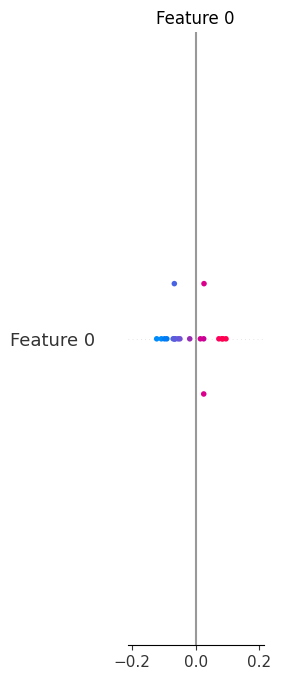

In [7]:
# Create a summary plot
shap.summary_plot(shap_values, X_val_tensor)

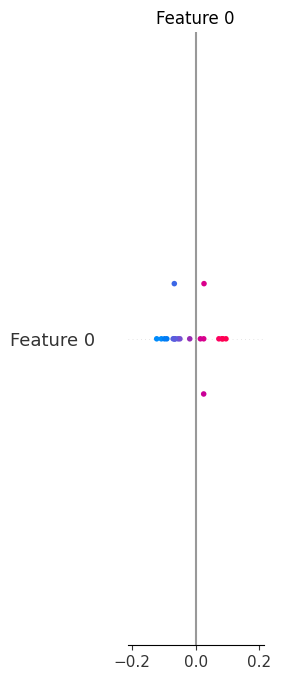

In [8]:
shap.summary_plot(shap_values, X_val_tensor, plot_type="bar")

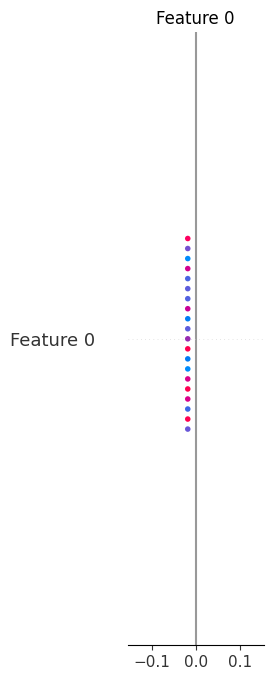

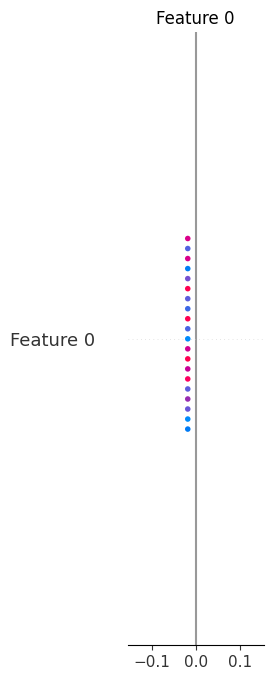

In [36]:
# SHAP values
shap_values = explainer.shap_values(X_val_tensor)

# Reshaping shap_values[0] to match X_val_np shape by broadcasting
shap_values_broadcasted = shap_values[0].reshape(1, 170, 1)  # Reshape to (1, 170, 1)

# Repeating so it matches the number of samples in X_val_tensor
shap_values_reshaped = np.repeat(shap_values_broadcasted, 20, axis=0)

X_val_np = X_val_tensor.numpy()



# Creating a summary plot
shap.summary_plot(shap_values_reshaped, X_val_np)

# & a feature importance plot
shap.summary_plot(shap_values_reshaped, X_val_np, plot_type="bar")

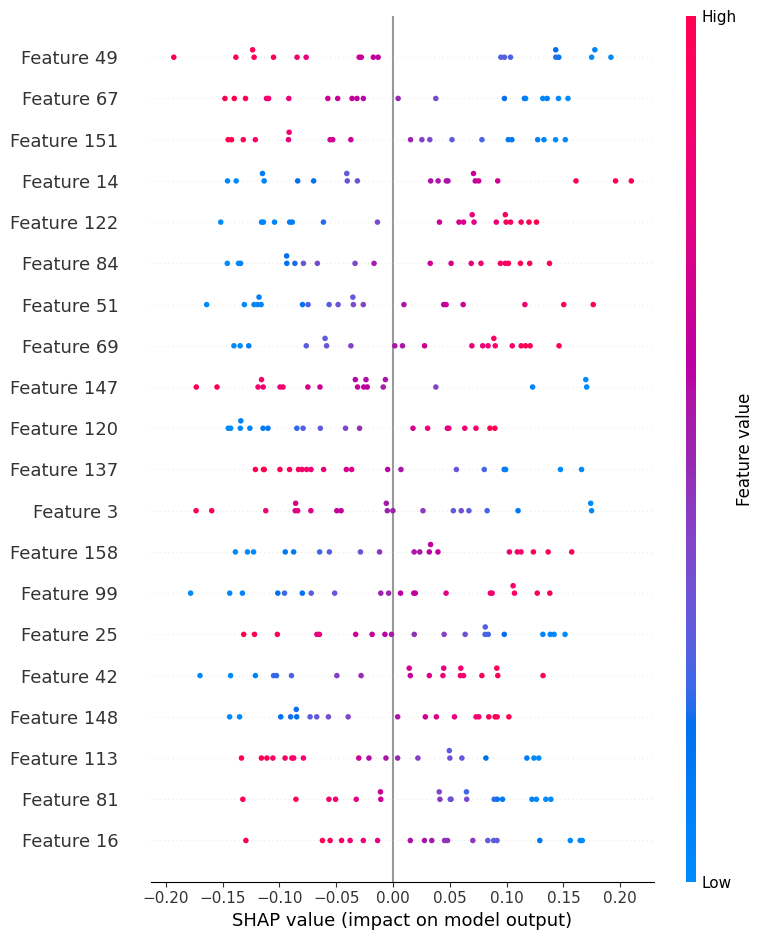

In [39]:
shap_values_reshaped = np.array(shap_values).reshape(X_val_tensor.shape)

# Creating a summary plot
shap.summary_plot(shap_values_reshaped, X_val_tensor.numpy())